# library

In [16]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import lightgbm
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
import fastai
from fastai.imports import *
from fastai.structured import *
import gc

from sklearn.model_selection import StratifiedShuffleSplit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
gc.enable()

# read file

## function

In [2]:
#'application_train',
files = [['bureau', 'SK_ID_BUREAU'],
         ['bureau_balance', 'SK_ID_BUREAU'],
         ['credit_card_balance', 'SK_ID_CURR'],
         ['installments_payments', 'SK_ID_CURR'], 
         ['POS_CASH_balance', 'SK_ID_CURR'],
         ['previous_application', 'SK_ID_CURR'],
         ['application_train'], ['application_test']]

In [4]:
def file_process(file_name = None, column_name = None, df_proc = None, limit = None):
    if file_name is not None:
        df = pd.read_csv(f'./data/{file_name}.csv', low_memory= False)
        if limit is not None:
            df = df[:limit]
        gc.collect()
        train_cats(df) #convert to category
        df_proc, num_cols = proc_df2(df, y_fld = None, max_n_cat= 10) #processing df
        del df; gc.collect()
    
    return df_proc, num_cols

In [3]:
def proc_df2(df, y_fld = None, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    
    y = y_fld
    if y_fld is not None:
        y = df[y_fld].values
        df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
        
    num_cols = df._get_numeric_data().columns
    sk_id_notin = ['SK_ID_BUREAU', 'SK_ID_CURR', 'SK_ID_PREV'] 
    num_cols = list([i for i in num_cols if i not in sk_id_notin and not i.endswith('na')])
    
    res = [pd.get_dummies(df, dummy_na=True), num_cols]
    if do_scale: res = res + [mapper]
    return res

## read data

In [315]:
app_train, _ = file_process(file_name = files[6][0])
app_train_y = app_train['TARGET']

In [316]:
app_test, _ = file_process(file_name = files[7][0])

In [317]:
app_train = app_train[list(app_test.columns)]

## split train and valid set

In [89]:
app_train = app_train[:100000]
app_train_y = app_train_y[:100000]

In [318]:
stratSplit = StratifiedShuffleSplit(1, test_size=0.2, random_state=42)
for train_idx,val_idx in stratSplit.split(app_train, app_train_y):
    x_train=app_train.iloc[train_idx]
    y_train=app_train_y[train_idx]
    
    x_val = app_train.iloc[val_idx]
    y_val = app_train_y[val_idx]

# lightgbm

## feature important

In [91]:
clf = LGBMClassifier(n_estimators=500,
                    learning_rate=0.1,
                    num_leaves=30,
                    colsample_bytree=.8,
                    subsample=.9,
                    max_depth=7,
                    reg_alpha=.1,
                    reg_lambda=.1,
                    min_split_gain=.01,
                    min_child_weight=2,
                    early_stopping_rounds=100,
                    verbose = -1)

In [ ]:
clf.fit(x_train, y_train, eval_set= [(x_val, y_val)],  eval_metric=['auc'])

In [93]:
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = x_train.columns
fold_importance_df["importance"] = clf.feature_importances_

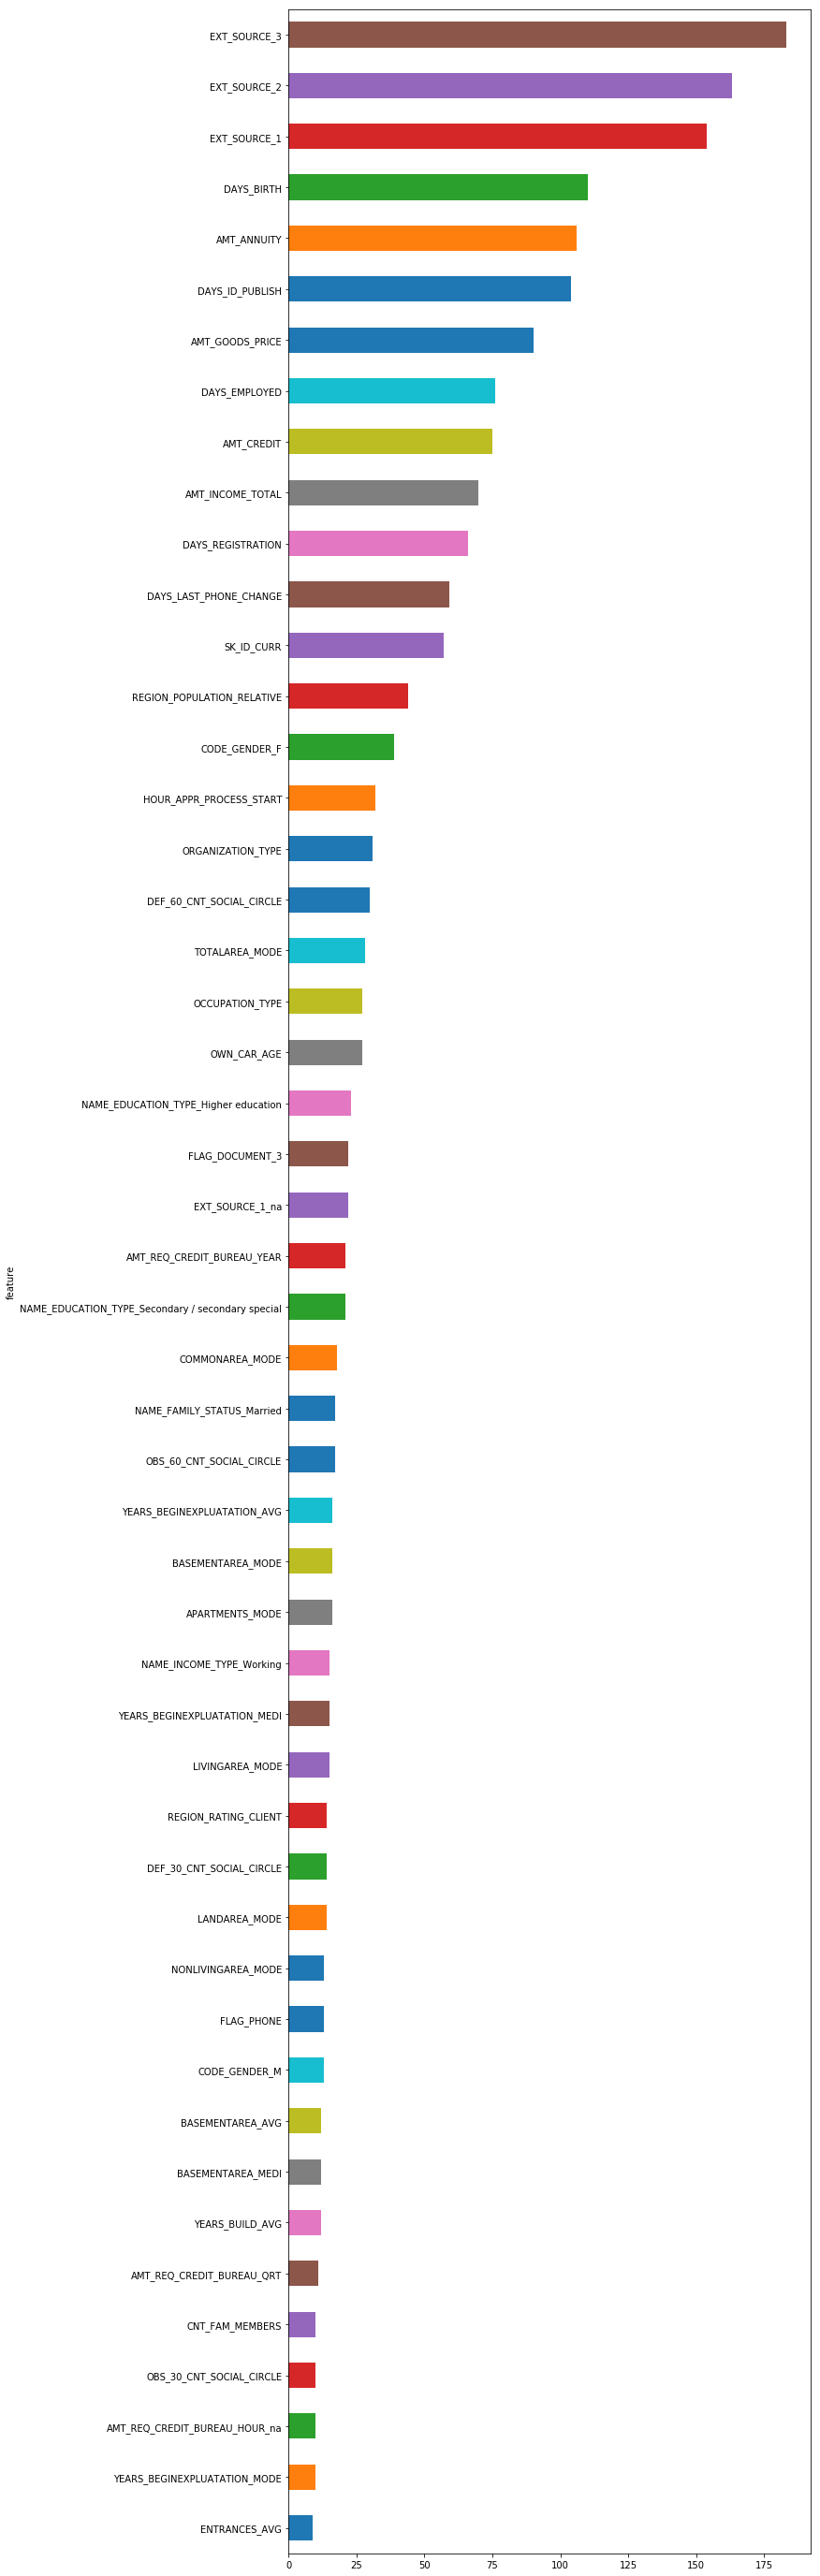

In [94]:
fold_importance_df.sort_values(by="importance", ascending=True)[-50:].plot(x = 'feature', 
                                                                           y = 'importance', 
                                                                           kind = 'barh', 
                                                                           figsize=(10,50), 
                                                                           legend=False )

In [95]:
keep_ft = fold_importance_df.sort_values(by="importance", ascending=True)[-25:]['feature'].values

In [96]:
keep_ft

array(['AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_1_na', 'FLAG_DOCUMENT_3',
       'NAME_EDUCATION_TYPE_Higher education', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'TOTALAREA_MODE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE', 'HOUR_APPR_PROCESS_START', 'CODE_GENDER_F',
       'REGION_POPULATION_RELATIVE', 'SK_ID_CURR', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH',
       'AMT_ANNUITY', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype=object)

In [97]:
x_train_k = x_train[keep_ft]
x_val_k = x_val[keep_ft]

In [ ]:
clf.fit(x_train_k, y_train, 
        eval_set= [(x_val_k, y_val)], 
        eval_metric=['auc'])

## remove redundant features

In [99]:
from scipy.cluster import hierarchy as hc

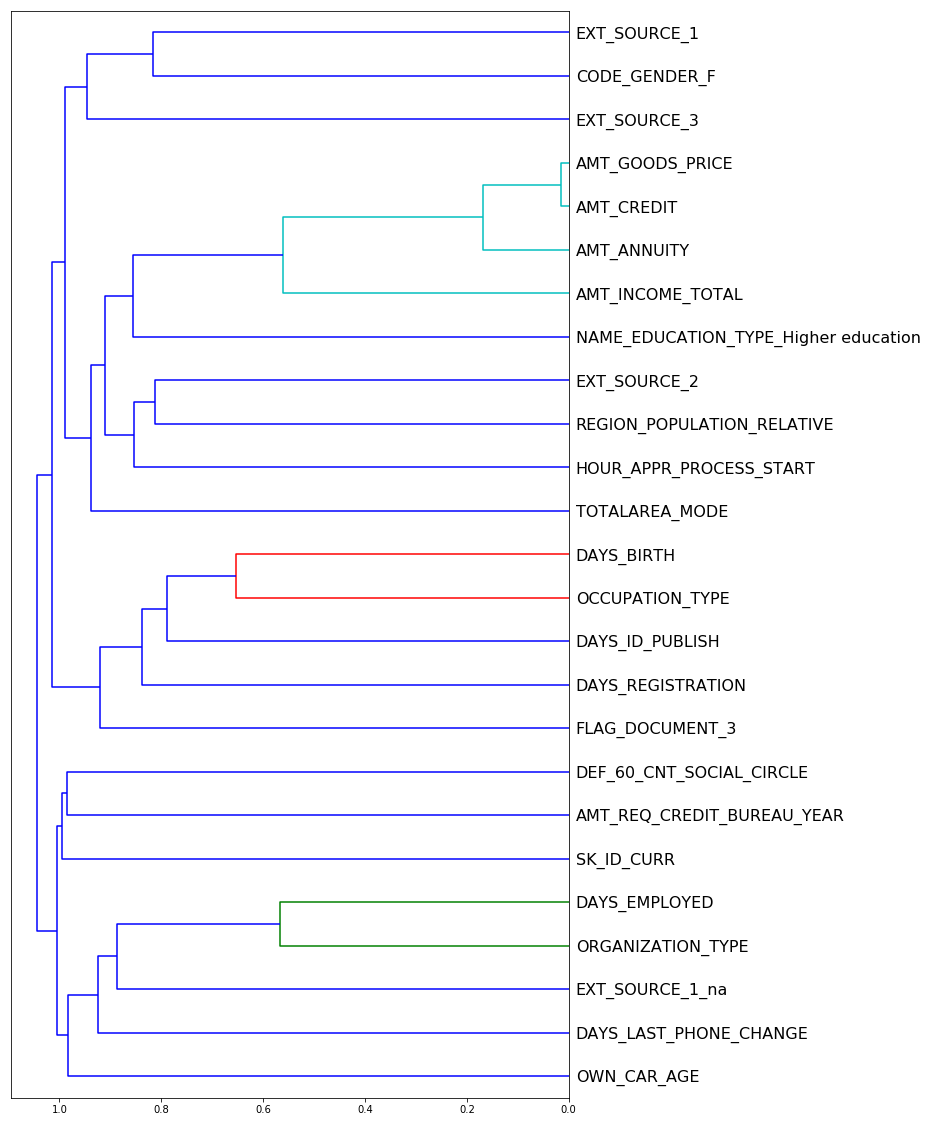

In [100]:
corr = np.round(scipy.stats.spearmanr(x_train_k).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(10,20))
dendrogram = hc.dendrogram(z, labels=x_train_k.columns, orientation='left', leaf_font_size=16)
plt.show()

In [ ]:
clf.fit(x_train_k.drop('AMT_CREDIT', axis=1), y_train, 
        eval_set= [(x_val_k.drop('AMT_CREDIT', axis=1), y_val)], 
        eval_metric=['auc'])

In [ ]:
clf.fit(x_train_k.drop('AMT_GOODS_PRICE', axis=1), y_train, 
        eval_set= [(x_val_k.drop('AMT_GOODS_PRICE', axis=1), y_val)], 
        eval_metric=['auc'])

In [103]:
keep_ft = ['AMT_REQ_CREDIT_BUREAU_YEAR', 'EXT_SOURCE_1_na', 'FLAG_DOCUMENT_3',
           'NAME_EDUCATION_TYPE_Higher education', 'OWN_CAR_AGE', 'OCCUPATION_TYPE', 'TOTALAREA_MODE',
           'DEF_60_CNT_SOCIAL_CIRCLE', 'ORGANIZATION_TYPE', 'HOUR_APPR_PROCESS_START', 'CODE_GENDER_F',
           'REGION_POPULATION_RELATIVE', 'SK_ID_CURR', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION',
           'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_ID_PUBLISH',
           'AMT_ANNUITY', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [104]:
x_train_k = x_train[keep_ft]
x_val_k = x_val[keep_ft]

## begin tune parameter

### Booster Parameters:  max depth and min_child weight 

In [240]:
max_depth = range(3,15,2)
min_child_weight = range(1,10,2)

dfa = pd.DataFrame.from_records([(x,y) for x in max_depth for y in min_child_weight],
                               columns = ['max_depth', 'min_child_weight'])

In [241]:
def model_eval(max_depth, min_child_weight):
    model = LGBMClassifier( n_estimators=500,
                            learning_rate=0.1,
                            
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                           
                            colsample_bytree=.8,
                            subsample=.9,
                           
                            reg_alpha=.1,
                            reg_lambda=.1,
                           
                            min_split_gain=.01,
                           
                            is_unbalance = True,
                            verbose=-1 )
    model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )
    return model.evals_result_['valid_0']['auc'][-1]

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval(max_depth = int(x[0]), min_child_weight = x[1]), axis = 1).values

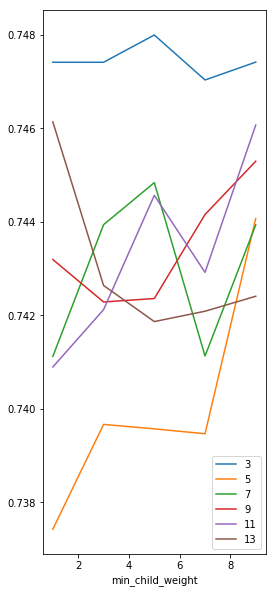

In [244]:
fig, ax = plt.subplots()
dfa.groupby(by = 'max_depth').plot(x= 'min_child_weight', y = 'auc', ax = ax,  kind = 'line', figsize=(4,10) )
ax.legend(max_depth)

In [ ]:
#try for min_child_weight higher than 5

In [248]:
dfa = pd.DataFrame.from_dict({'min_child_weight': range(5,60,2)})

In [249]:
def model_eval_2(min_child_weight):
    model = LGBMClassifier( n_estimators=500,
                            learning_rate=0.1,
                           
                            max_depth=3, #tuned
                            min_child_weight=min_child_weight,
                           
                            colsample_bytree=.8,
                            subsample=.9,
                           
                            reg_alpha=.1,
                            reg_lambda=.1,
                           
                            min_split_gain=.01,
                           
                            is_unbalance = True,
                            verbose=-1 )
    model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )
    return model.evals_result_['valid_0']['auc'][-1]               

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_2(min_child_weight = x[0]), axis = 1).values

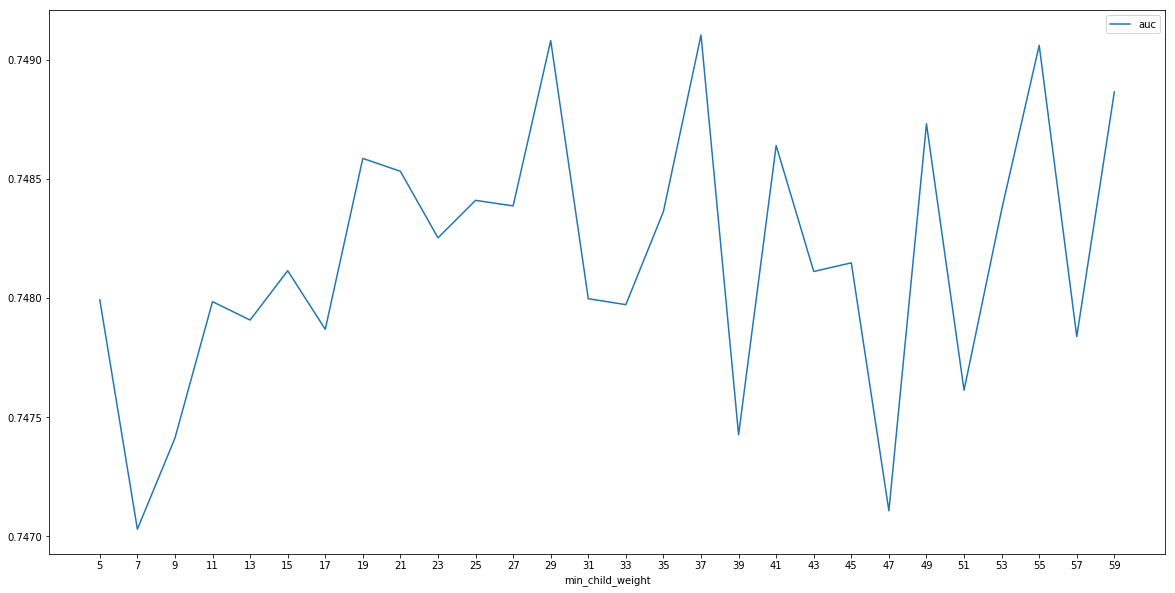

In [251]:
dfa.plot(x= 'min_child_weight', xticks=range(5,60,2), y = 'auc', kind = 'line', figsize=(20,10) )

In [255]:
dfa.sort_values(by = 'auc', ascending= False).head()

,min_child_weight,auc
16,37,0.749103
12,29,0.749080
25,55,0.749060
27,59,0.748865
22,49,0.748731


In [ ]:
#look closer

In [256]:
dfa = pd.DataFrame.from_dict({'min_child_weight': [36,37,38]})

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_2(min_child_weight = x[0]), axis = 1).values

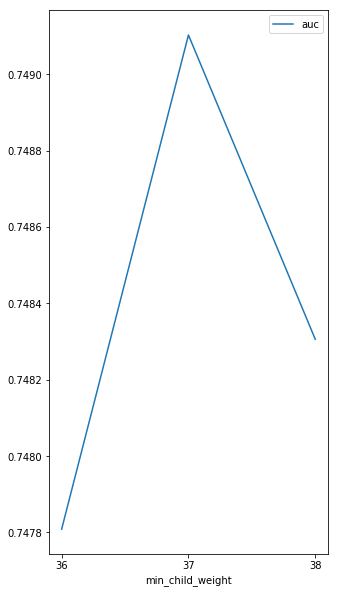

In [258]:
dfa.plot(x= 'min_child_weight', xticks=  [36,37,38], y = 'auc', kind = 'line', figsize=(5,10))

In [ ]:
min_child_weight = 37 and max_depth = 3

### Booster Parameters: min_split_gain

In [259]:
def model_eval_3(min_split_gain):
    model = LGBMClassifier( n_estimators=500,
                            learning_rate=0.1,
                           
                            max_depth=3, #tuned
                            min_child_weight=37, #tuned
                           
                            min_split_gain=min_split_gain, 
                            
                            colsample_bytree=.8,
                            subsample=.9,
                           
                            reg_alpha=.1,
                            reg_lambda=.1,
                           
                            is_unbalance = True,
                            verbose=-1 )
    model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )
    return model.evals_result_['valid_0']['auc'][-1]     

In [260]:
dfa = pd.DataFrame.from_dict({'min_split_gain': [i/10 for i in range(0,16,2)]})

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_3(min_split_gain = x[0]), axis = 1).values

In [264]:
dfa.sort_values(by = 'auc', ascending= False).head()

,min_split_gain,auc
5,1.0,0.749195
6,1.2,0.749138
7,1.4,0.749138
0,0.0,0.749103
1,0.2,0.749103


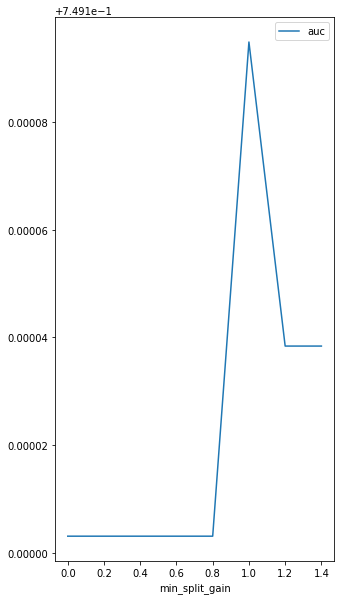

In [262]:
dfa.plot(x= 'min_split_gain', xticks= [i/10 for i in range(0,16,2)], y = 'auc', kind = 'line', figsize=(5,10) )

In [205]:
min_split_gain = 1

### Booster Parameters: bagging_fraction, feature_fraction

In [274]:
bagging_fraction=  feature_fraction = [i/10.0 for i in range(2,10)]
dfa = pd.DataFrame.from_records([(x,y) for x in bagging_fraction for y in feature_fraction],
                               columns = ['bagging_fraction', 'feature_fraction'])

In [275]:
def model_eval_4(bagging_fraction, feature_fraction ):
    model = LGBMClassifier( n_estimators=500,
                            learning_rate=0.1,
                           
                            max_depth=3, #tuned
                            min_child_weight=37, #tuned
                           
                            min_split_gain = 1, #tuned
                            
                            bagging_fraction = bagging_fraction,
                            feature_fraction = feature_fraction,                           
                           
                            reg_alpha=.1,
                            reg_lambda=.1,
                           
                            is_unbalance = True,
                            verbose=-1 )
    model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )
    return model.evals_result_['valid_0']['auc'][-1]  

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_4(bagging_fraction = x[0],feature_fraction = x[1]), axis = 1).values

In [277]:
dfa.sort_values(by = 'auc', ascending=False).head()

,bagging_fraction,feature_fraction,auc
37,0.6,0.7,0.750098
58,0.9,0.4,0.749650
48,0.8,0.2,0.749601
62,0.9,0.8,0.749195
53,0.8,0.7,0.748974


In [ ]:
#closer look

In [278]:
bagging_fraction= [0.55, 0.6, 0.65]
feature_fraction = [0.65, 0.7, 0.75]
dfa = pd.DataFrame.from_records([(x,y) for x in bagging_fraction for y in feature_fraction],
                               columns = ['bagging_fraction', 'feature_fraction'])

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_4(bagging_fraction = x[0],feature_fraction = x[1]), axis = 1).values

In [280]:
dfa.sort_values(by = 'auc', ascending=False)

,bagging_fraction,feature_fraction,auc
4,0.60,0.70,0.750098
3,0.60,0.65,0.749407
1,0.55,0.70,0.747793
5,0.60,0.75,0.747640
8,0.65,0.75,0.747230
6,0.65,0.65,0.747146
7,0.65,0.70,0.747034
2,0.55,0.75,0.746561
0,0.55,0.65,0.746135


In [ ]:
bagging_fraction = 0.6
feature_fraction = 0.7

### Regularization Parameters: reg_alpha, reg_lambda

In [281]:
reg_alpha = reg_lambda = [0, 0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1]
dfa = pd.DataFrame.from_records([(x,y) for x in reg_alpha for y in reg_lambda],
                               columns = ['reg_alpha', 'reg_lambda'])

In [282]:
def model_eval_5(reg_alpha, reg_lambda ):
    model = LGBMClassifier( n_estimators=500,
                            learning_rate=0.1,
                           
                            max_depth=3, #tuned
                            min_child_weight=37, #tuned
                           
                            min_split_gain = 1, #tuned
                            
                            bagging_fraction = 0.6,#tuned
                            feature_fraction = 0.7, #tuned
                           
                            reg_alpha=reg_alpha, 
                            reg_lambda=reg_lambda,
                           
                            is_unbalance = True,
                            verbose=-1 )
    model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )
    return model.evals_result_['valid_0']['auc'][-1]  

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_5(reg_alpha = x[0],reg_lambda = x[1]), axis = 1).values

In [286]:
dfa.sort_values(by = 'auc', ascending=False).head()

,reg_alpha,reg_lambda,auc
22,0.010,0.800,0.750183
14,0.001,0.800,0.750182
6,0.000,0.800,0.750182
26,0.100,0.010,0.750134
25,0.100,0.001,0.750134


In [ ]:
reg_alpha = [0.005,0.01,0.015]
reg_lambda = [0.75, 0.8, 0.85]
dfa = pd.DataFrame.from_records([(x,y) for x in reg_alpha for y in reg_lambda], columns = ['reg_alpha', 'reg_lambda'])
dfa['auc'] = dfa.apply(lambda x: model_eval_5(reg_alpha = x[0],reg_lambda = x[1]), axis = 1).values

In [288]:
dfa.sort_values(by = 'auc', ascending=False).head()

,reg_alpha,reg_lambda,auc
4,0.010,0.80,0.750183
7,0.015,0.80,0.750183
1,0.005,0.80,0.750183
3,0.010,0.75,0.750168
6,0.015,0.75,0.750168


In [ ]:
reg_alpha = 0.01
reg_lambda = 0.8

### Core Parameters: n_estimators and learning_rate

In [292]:
def model_eval_6(n_estimators, learning_rate ):
    model = LGBMClassifier( n_estimators=n_estimators,
                            learning_rate=learning_rate,
                           
                            max_depth=3, #tuned
                            min_child_weight=37, #tuned
                           
                            min_split_gain = 1, #tuned
                            
                            bagging_fraction = 0.6,#tuned
                            feature_fraction = 0.7, #tuned
                           
                            reg_alpha=0.01, #tuned
                            reg_lambda=0.8, #tuned
                           
                            is_unbalance = True,
                            verbose=-1 )
    model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )
    return model.evals_result_['valid_0']['auc'][-1]  

In [311]:
n_estimators = [200, 500, 800, 1000, 1500, 2000, 4000]
learning_rate = [0.1, 0.05, 0.01, 0.005, 0.001]
dfa = pd.DataFrame.from_records([(x,y) for x in n_estimators for y in learning_rate], columns = ['n_estimators', 'learning_rate'])

In [ ]:
dfa['auc'] = dfa.apply(lambda x: model_eval_6(n_estimators = int(x[0]),learning_rate = x[1]), axis = 1).values

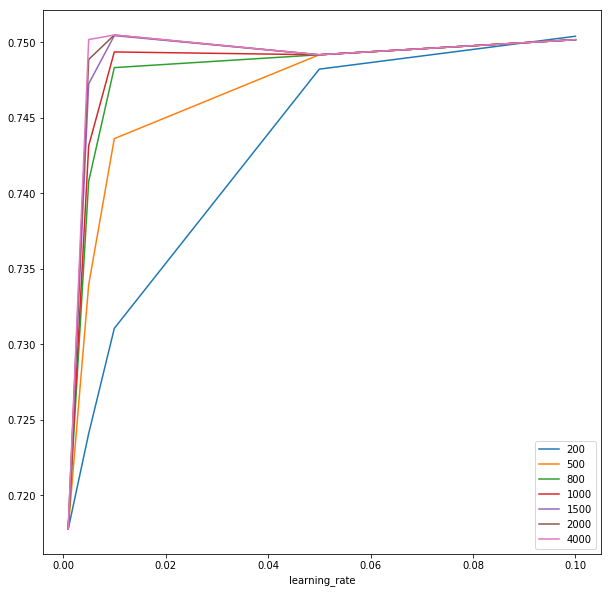

In [313]:
fig, ax = plt.subplots()
dfa.groupby(by = 'n_estimators').plot(x= 'learning_rate', y = 'auc', ax = ax,  kind = 'line', figsize=(10,10) )
ax.legend(n_estimators)

In [314]:
dfa.sort_values(by = 'auc', ascending=False).head()

,n_estimators,learning_rate,auc
32,4000,0.010,0.750494
27,2000,0.010,0.750494
22,1500,0.010,0.750453
0,200,0.100,0.750411
33,4000,0.005,0.750193


In [ ]:
learning_rate = 0.01
n_estimators = 2000

# predict test set

In [319]:
x_train_k = x_train[keep_ft]
x_val_k = x_val[keep_ft]

In [ ]:
model = LGBMClassifier( n_estimators=2000,
                        learning_rate=0.01,

                        max_depth=3, #tuned
                        min_child_weight=37, #tuned

                        min_split_gain = 1, #tuned

                        bagging_fraction = 0.6,#tuned
                        feature_fraction = 0.7, #tuned

                        reg_alpha=0.01, #tuned
                        reg_lambda=0.8, #tuned

                        is_unbalance = True,
                        verbose=-1 )
model.fit(x_train_k, y_train, eval_set= [(x_val_k, y_val)], eval_metric=['auc'], early_stopping_rounds=100 )

In [321]:
preds_df = app_test[['SK_ID_CURR']]

In [323]:
preds_df['TARGET'] = model.predict_proba(app_test[keep_ft])[:, 1]

/home/zero/anaconda/envs/fastai-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [325]:
preds_df.to_csv('light_gbm_tuning.csv', index=False)